# Santander Customer Transaction Prediction

In this challenge, we invite Kagglers to help us identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted.

https://www.kaggle.com/c/santander-customer-transaction-prediction


### Goal: Will they transact?

This is a tabular competition looking for a binary classification. 

### EDA
A large part of this problem seemed to be trying to figure out how to pull more information from the features.

# Setup

In [34]:
# Basic Setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [35]:
# Loading in functions... just load everything
import pickle
import ray
import pyarrow.parquet as pq
from sklearn.preprocessing import *

In [36]:
# Loading in functions
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import *

In [37]:
# Loading in functions
import fastai
from fastai.imports import *
from fastai import *
from fastai.tabular import *
from fastai.metrics import error_rate
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.fft import *
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

# Helps confirms the sets I was using when on github
print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('Python: {}'.format(sys.version))
print('Fastai: {}'.format(fastai.__version__))
#Selecting the right GPU
torch.cuda.set_device(0)

pandas: 0.23.4
numpy: 1.15.4
Python: 3.7.1 (default, Dec 14 2018, 19:28:38) 
[GCC 7.3.0]
Fastai: 1.0.51


In [38]:
# Try to limit outputs
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10

### Fuctions

In [39]:
#https://www.kaggle.com/jiweiliu/fast-pdf-calculation-with-correlation-matrix
# This did not turn out to be useful
def logloss(y,yp):
    yp = np.clip(yp,1e-5,1-1e-5)
    return -y*np.log(yp)-(1-y)*np.log(1-yp)
    
def reverse(train,test):
    reverse_list = [0,1,2,3,4,5,6,7,8,11,15,16,18,19,
                22,24,25,26,27,41,29,
                32,35,37,40,48,49,47,
                55,51,52,53,60,61,62,103,65,66,67,69,
                70,71,74,78,79,
                82,84,89,90,91,94,95,96,97,99,
                105,106,110,111,112,118,119,125,128,
                130,133,134,135,137,138,
                140,144,145,147,151,155,157,159,
                161,162,163,164,167,168,
                170,171,173,175,176,179,
                180,181,184,185,187,189,
                190,191,195,196,199]
    reverse_list = ['var_%d'%i for i in reverse_list]
    for col in reverse_list:
        train[col] = train[col]*(-1)
        test[col] = test[col]*(-1)
    return train,test

def scale(tr,te):
    for col in tr.columns:
        if col.startswith('var_'):
            mean,std = tr[col].mean(),tr[col].std()
            tr[col] = (tr[col]-mean)/std
            te[col] = (te[col]-mean)/std
    return tr,te

def getp_vec_sum(x,x_sort,y,std,c=0.5):
    # x is sorted
    left = x - std/c
    right = x + std/c
    p_left = np.searchsorted(x_sort,left)
    p_right = np.searchsorted(x_sort,right)
    p_right[p_right>=y.shape[0]] = y.shape[0]-1
    p_left[p_left>=y.shape[0]] = y.shape[0]-1
    return (y[p_right]-y[p_left])

def get_pdf(tr,col,x_query=None,smooth=3):
    std = tr[col].std()
    df = tr.groupby(col).agg({'target':['sum','count']})
    cols = ['sum_y','count_y']
    df.columns = cols
    df = df.reset_index()
    df = df.sort_values(col)
    y,c = cols
    
    df[y] = df[y].cumsum()
    df[c] = df[c].cumsum()
    
    if x_query is None:
        rmin,rmax,res = -5.0, 5.0, 501
        x_query = np.linspace(rmin,rmax,res)
    
    dg = pd.DataFrame()
    tm = getp_vec_sum(x_query,df[col].values,df[y].values,std,c=smooth)
    cm = getp_vec_sum(x_query,df[col].values,df[c].values,std,c=smooth)+1
    dg['res'] = tm/cm
    dg.loc[cm<500,'res'] = 0.1
    return dg['res'].values

def get_pdfs(tr):
    y = []
    for i in range(200):
        name = 'var_%d'%i
        res = get_pdf(tr,name)
        y.append(res)
    return np.vstack(y)

def print_corr(corr_mat,col,bar=0.97):
    print(col)
    cols = corr_mat.loc[corr_mat[col]>bar,col].index.values
    cols_ = ['var_%s'%(i.split('_')[-1]) for i in cols]
    print(cols)
    return cols

# Load Data
Gets the data all put together

In [40]:
# Load data, save as pickle, always load as pckly from now on.

#df = pd.read_csv('/home/jd/data/santander/train.csv')
#pickle.dump(df, open( "/home/jd/data/santander/train.p", "wb" ) )
df=pickle.load(open( "/home/jd/data/santander/train.p", "rb" ) )


#test_df = pd.read_csv('/home/jd/data/santander/test.csv')
#pickle.dump(test_df, open( "/home/jd/data/santander/test.p", "wb" ) )
test_df=pickle.load(open( "/home/jd/data/santander/test.p", "rb" ) )

In [41]:
#https://www.kaggle.com/c/bnp-paribas-cardif-claims-management/discussion/20247
df.describe()

,target,var_0,var_1,var_2,var_3,...,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,...,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,...,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,...,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,...,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,...,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,...,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,...,4.272900,18.321500,12.000400,26.079100,28.500700


## Load Data way #2

In [ ]:
# Just another way to load data
df_train = pd.read_csv('/home/jd/data/santander/train.csv', index_col=0)
y_train = df_train.pop('target')
len_train = len(df_train)
df_test = pd.read_csv('/home/jd/data/santander/test.csv', index_col=0)
df_all = pd.concat((df_train, df_test), sort=False)
prev_cols = df_all.columns

In [ ]:
#Check Remove Pre Process
scaler = StandardScaler()
df_all[prev_cols] = scaler.fit_transform(df_all[prev_cols])
df = df_all[0:len_train]
test_df = df_all[len_train:]
df['target']=y_train

# Data Preprocess
Any Required Preprocess. None needed here.

In [42]:
# Any missing data? Nope
df.isnull().values.any()

False

In [43]:
# What can we see from the values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


# Validation Set Creation
Create the validation set to be used

## Validation Set / Random group to save for later

In [44]:
# Create a validation set with 90% of data
msk = np.random.rand(len(df)) < 0.9

# we save valida for later
valida = df[~msk]
df = df[msk]

In [45]:
len(df), len(valida)

(179801, 20199)

## Augment
Perform a shuffle on the data, which helps create more data. 
Take a look at the Kaggle notebook, makes way more sense. 
https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment

In [ ]:
#https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment
def augment(x,y,t=3):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
    #for i in range(2//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [ ]:

feature_columns_to_use=list(df.columns)
feature_columns_to_use.remove('target')
#feature_columns_to_use.remove('code_id')

In [ ]:
#features = columns
df[feature_columns_to_use]
X_train, y_train = df[feature_columns_to_use], df['target']

In [ ]:
X_t, y_t = augment(X_train.values, y_train.values)
X_t = pd.DataFrame(X_t)
X_t = X_t.add_prefix('var_')

In [ ]:
X_t[:5]

In [ ]:
X_t['target']= y_t

In [ ]:
X_t['ID_code']=X_t.index
X_t['ID_code']=X_t['ID_code'].astype(object)

In [ ]:
valida['target'].value_counts()

In [ ]:
df['target'].value_counts()

In [ ]:
df=pd.concat([X_t, valida],sort=False)

In [ ]:
len(df)-len(valida)

In [ ]:
df[396098:]

# Oversampling
The numbers are a little off for and we want to increase the number of target samples.

In [46]:
# divides into target or not.
dfTarget=df.loc[df['target'] == 1]
dfNot=df.loc[df['target'] == 0]

In [47]:
# Determine the number of differences
diff=len(dfNot)//len(dfTarget)
len(dfTarget),len(dfNot), diff

(18095, 161706, 8)

In [48]:
# have i

# run this number of times
runN = 2
for x in range(1, runN):
    df=pd.concat([df, dfTarget],sort=False)
    
# Recalculate teh number of pos or not
dfTarget=df.loc[df['target'] == 1]
dfNot=df.loc[df['target'] == 0]
len(dfTarget),len(dfNot)

(36190, 161706)

In [49]:
#We put it back together and keep the indexes for later.
df=pd.concat([df, valida],sort=False)
valid_idx = range(len(df)-len(valida),len(df))

# EDA
Not my best work. I tried pulling in a whole number of methods to explore the data.

## Seaborn Plots

In [ ]:
# Seaborn Plots are pretty
import seaborn as sns
sns.set(style="ticks")

In [ ]:
# Comparing var 81 and var 139
g = sns.pairplot(df, height=10, vars=["var_81", "var_139"], hue="target" )#plot_kws={'scatter_kws': {'alpha': 0.1}})

In [ ]:
# Fancier Graphs for all the important variables
g = sns.pairplot(df, height=10, vars=["var_81", "var_139", "var_12","var_110","var_53",], hue="target" )#plot_kws={'scatter_kws': {'alpha': 0.1}})

## Graph Plotting
Just other ways to look at plotting

In [ ]:
#Sets us up to look at with and without target
dfTarget=df.loc[df['target'] == 1]
dfNot=df.loc[df['target'] == 0]

In [ ]:
# Lets look at the column for targets and not target
# They are different but does that matter?
dfTarget["var_81"].describe(), dfNot["var_81"].describe()

In [ ]:
fig, ax = plt.subplots()

colors = {1:'red', 0:'blue'}

ax.scatter(df['var_81'], df['var_139'], c=df['target'].apply(lambda x: colors[x]), alpha = .01)
plt.figure(figsize=(50,30))

In [ ]:
fig, ax = plt.subplots()

colors = {1:'red', 0:'blue'}

ax.scatter(df['var_81'], df['var_139'], c=df['target'].apply(lambda x: colors[x]), alpha = .01)
plt.figure(figsize=(50,30))
plt.show()

## All the Values 
Let's just graph everything.

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

cols = [f'var_{i}' for i in range(200)]

In [ ]:
width_num = 7
height_num = 40
fig = plt.figure(figsize=[4*width_num,3*height_num])
for i in tqdm_notebook(range(200)):
    ax = fig.add_subplot(height_num,width_num,i+1)
    _ = ax.hist(df[cols[i]], bins=100, alpha=0.5, density=True, label='train')
    _ = ax.hist(test_df[cols[i]], bins=100,alpha=0.5, density=True, label='test')
    _ = ax.set_title(cols[i])
    ax.legend()

In [ ]:
## 

## Fake Data
Didn't see this as valuable

In [ ]:
#https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split

In [ ]:
#https://www.kaggle.com/mitjasha/854-easy-nn-for-santander
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## PCA Data
fig, ax = plt.subplots(1, 2, figsize = (24, 12))
pca = PCA()
X_reduced0 = pca.fit_transform(X_train0)
X_reduced1 = pca.fit_transform(X_train1)


ax[0].scatter(X_reduced0[:, 0], X_reduced0[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('bwr', 2))
ax[0].set_title('PCA projection StdScalar')

ax[1].scatter(X_reduced1[:, 0], X_reduced1[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('bwr', 2))
ax[1].set_title('PCA projection Robust')

print(pca.n_components_)

# Feature Engineering
Creating new Features

## Binning - Not Useful
Turn some items into bins and category driven variables


In [ ]:
def makebin(df,var,var2):
    IQR = df[var].quantile([0.75]).values - df[var].quantile([0.25]).values #inter-quartile range
    n = 200000 #size of our dataframe
    binsize = 2 * IQR/n**(1/3) #Freedman-Diaconis rule to define the bin size
    binnumber = int((df[var].max() - df[var].min())/binsize)

    df[var2]= df[var].values//binsize
    df[var2]= df[var2].astype('category')
    return df

def makebinall(df):
    df = makebin(df, 'var_81','var_210')
    df = makebin(df, 'var_139','var_211')
    df = makebin(df, 'var_12','var_212')
    df = makebin(df, 'var_53','var_213')
    df = makebin(df, 'var_26','var_214')
    df = makebin(df, 'var_6','var_215')
    df = makebin(df, 'var_146','var_216')
    df = makebin(df, 'var_174','var_217')
    return df

def makebinall2(df):
    df = makebin(df, 'var_12','var_200')
    df = makebin(df, 'var_13','var_201')
    df = makebin(df, 'var_108','var_202')
    df = makebin(df, 'var_126','var_203')
    df = makebin(df, 'var_68','var_204')
    #df = makebin(df, 'var_6','var_215')
    #df = makebin(df, 'var_146','var_216')
    #df = makebin(df, 'var_174','var_217')
    return df

In [ ]:
#columns=['var_12','var_13','var_108','var_126','var_68']
#for var in df.columns:
#    print(var)
#    hist, bin_edges = np.histogram(df[var], bins=1000, density=True)
#    df['test_'+var] = [ hist[np.searchsorted(bin_edges,ele)-1] for ele in f[var] ]

df= makebinall2(df)
test_df = makebinall2(test_df)

## Distance and Cardinality - Not useful
Looking at a 2-D plot and pulling out vector and direction would we get anything

In [ ]:
def Vec_arc(df, f1, f2, name):
    df[name] = np.sqrt(abs(df[f1])**2+abs(df[f2])**2)
    return df

def Vec_arc_all(df):
    df = Vec_arc(df, "var_53", "var_26", "var_200")
    
    return df

def Vec_arc_all(df):
    return df

## Shift Bias - Not useful
There are problems there seems to be an inflection point where things are more likely to be one thing than another

In [ ]:
def leftfeat(df, name, var, bias):
    df[name] = -df[var] + bias
    return df

def rightfeat(df, name, var, bias):
    df[name] = df[var] + bias
    return df

def ShiftFE(df):
    #('f81', 12355.496952399995), L @ -.8
    leftfeat(df,"var_200","var_81",-.8)
    
     #('f139', 12355.496952399995), L @ -.8
    leftfeat(df,"var_201","var_139",-.8)

    # ('f12', 10631.7287359), L @ -.5
    leftfeat(df,"var_202","var_12",-.5)

    # ('f110', 8968.073885599999), R @ 1
    rightfeat(df,"var_203","var_110",.5)

    # ('f53', 8880.9331203), R @ .5
    rightfeat(df,"var_204","var_53",.5)

    # ('f26', 8518.611027600002), R @ .75
    rightfeat(df,"var_205","var_26",.75)

    # ('f6', 8348.653376200002), R @ .25
    rightfeat(df,"var_206","var_6", .25)

    # ('f146', 7815.327076099999), L @ -1
    leftfeat(df,"var_207","var_146",-1)

    # ('f174', 7608.578131499998) L @ -1
    leftfeat(df,"var_208","var_174",-1)

    # f0 R @ .8
    rightfeat(df,"var_209","var_0",.8)
    
    return df

#ShiftFE(df_all)

# Measure Feature Importance
Ways to measure those new features

## Scipy Cluster

In [ ]:
df.info()

In [ ]:
# Removing redundant features
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(10,40))
dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=16)
plt.show()

## XGboost
https://www.kaggle.com/cbrogan/xgboost-example-python
Let's run XGboost to see Feature Importance

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

from numpy import loadtxt
from matplotlib import pyplot

from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)


In [ ]:
# feature columsn should not include target or ID_Code
feature_columns_to_use = list(df.columns)
feature_columns_to_use.remove('target')
feature_columns_to_use.remove('ID_code')

In [ ]:
#feature_columns_to_use

In [ ]:
#big X is the total dataframe after test_df is added
big_X = df[feature_columns_to_use].append(test_df[feature_columns_to_use])
big_X_imputed = DataFrameImputer().fit_transform(big_X)

le = LabelEncoder()
#for feature in nonnumeric_columns:
#    big_X_imputed[feature] = le.fit_transform(big_X_imputed[feature])

In [ ]:
# split off the train and test X
train_X = big_X_imputed[0:df.shape[0]].as_matrix()
test_X = big_X_imputed[df.shape[0]::].as_matrix()
train_y = df['target']

In [ ]:
# Yes Train_x works
#train_X

#### Run it gbm

In [ ]:
# Run it! otherwise, save the results so it doesn't take that long
gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05).fit(train_X, train_y)
predictions = gbm.predict(test_X)
#if you just ran it... save it
pickle.dump(gbm, open( "/home/jd/data/santander/gbm.p", "wb" ) )

In [ ]:
#defines defines an empty one and then saves everything
gbm = xgb.XGBClassifier()
gbm=pickle.load(open( "/home/jd/data/santander/gbm.p", "rb" ) )

In [ ]:
#https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
pyplot.bar(range(len(gbm.feature_importances_)), gbm.feature_importances_)
pyplot.show()

In [ ]:
df[:5]

In [ ]:
#https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7
# #Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
gain=gbm.get_booster().get_score(importance_type= 'gain')
sorted_gain = sorted(gain.items(), key=lambda kv: kv[1],reverse = True)
sorted_gain

In [ ]:
gain=gbm.get_booster().get_score(importance_type= 'total_gain')
sorted_gain = sorted(gain.items(), key=lambda kv: kv[1],reverse = True)
sorted_gain[:10]

In [ ]:
gain=gbm.get_booster().get_score(importance_type= 'cover')
sorted_gain = sorted(gain.items(), key=lambda kv: kv[1],reverse = True)
sorted_gain[:10]

In [ ]:
gain=gbm.get_booster().get_score(importance_type= 'weight')
sorted_gain = sorted(gain.items(), key=lambda kv: kv[1],reverse = True)
sorted_gain[:10]

# Test Run!
With an NN

In [50]:
dep_var = 'target'
procs = [FillMissing, Categorify, Normalize]
path = Path('/home/jd/data/santander')

In [51]:
#cat_names =  ['var_200', 'var_201', 'var_202', 'var_203', 'var_204']#, 'var_215', 'var_216', 'var_217']

In [52]:
cont_names= list(df.columns)
cont_names.remove('target')
cont_names.remove('ID_code')
cat_names = ()

In [53]:
cont_names=[x for x in cont_names if x not in cat_names]

In [54]:
df['target'].describe()

count    218095.000000
mean          0.175121
std           0.380071
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: target, dtype: float64

In [55]:
#data.show_batch(rows=10)
from sklearn.metrics import roc_auc_score

def auc_score1(y_score,y_true):
    return torch.tensor(roc_auc_score(y_true,y_score[:,1]))

In [56]:
# Test data is stored here.
test = TabularList.from_df(test_df, path=path, cat_names=None ,cont_names=cont_names)

In [57]:
#if you made a validation set, should be here
valid_idx, len(df)

(range(197896, 218095), 218095)

In [59]:
data = (TabularList.from_df(df, path=path, cat_names=None, cont_names=cont_names, procs=procs)
                          # .split_by_rand_pct(valid_pct=0.5, seed=42)
                           .split_by_idx(valid_idx)
                           .label_from_df(cols=dep_var, label_cls=CategoryList)
                           .add_test(test)
                           .databunch(bs=512))

In [60]:
learn = tabular_learner(data, layers=[2000,500], 
                        ps=[0.1,0.02],
                        emb_drop=0.07, 
                        y_range=None,
                        metrics=[accuracy, auc_score1]
                        #metrics=accuracy
                       )

In [61]:
from fastai.callbacks.tracker import EarlyStoppingCallback
from fastai.callbacks.tracker import SaveModelCallback

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-04


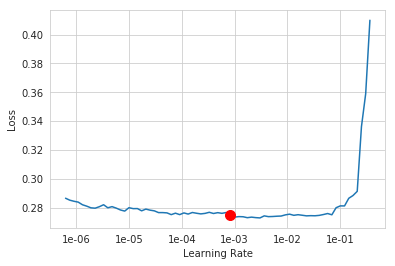

In [70]:
# See plot
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [71]:
learn.fit_one_cycle(10,1.5e-03, 
                    callbacks=[SaveModelCallback(learn, every='improvement', monitor='auc_score1', name='best')], wd=0.1)

epoch,train_loss,valid_loss,accuracy,auc_score1,time
0,0.267007,0.241050,0.911382,0.873576,00:02
1,0.255742,0.243474,0.908758,0.867149,00:02
2,0.243160,0.241973,0.910590,0.859767,00:02
3,0.214066,0.270295,0.904154,0.853442,00:02
4,0.182101,0.297272,0.897074,0.841453,00:02
5,0.151755,0.322024,0.897421,0.825665,00:02
6,0.122636,0.367357,0.898955,0.817611,00:02
7,0.102961,0.395384,0.895589,0.817052,00:02
8,0.085064,0.427417,0.897916,0.812604,00:02
9,0.080917,0.432356,0.895094,0.812117,00:02


Better model found at epoch 0 with auc_score1 value: 0.8735761046409607.


In [72]:
learn.load('best')

Learner(data=TabularDataBunch;

Train: LabelList (197896 items)
x: TabularList
var_0 -0.5867; var_1 -1.2816; var_2 0.4324; var_3 -0.8353; var_4 0.2328; var_5 -0.5423; var_6 -0.3499; var_7 0.6098; var_8 -1.5663; var_9 -1.4566; var_10 0.4613; var_11 1.0688; var_12 -0.0336; var_13 -1.6897; var_14 0.5615; var_15 -0.0153; var_16 -1.4011; var_17 -0.2311; var_18 -1.4018; var_19 2.2786; var_20 -0.4643; var_21 -0.1109; var_22 -0.6165; var_23 -1.0306; var_24 0.9956; var_25 -0.8247; var_26 -0.1995; var_27 0.4781; var_28 -0.7604; var_29 0.3583; var_30 0.9282; var_31 1.1714; var_32 -1.3045; var_33 0.4992; var_34 -0.4324; var_35 1.2847; var_36 -0.4728; var_37 0.8942; var_38 -1.3970; var_39 0.7910; var_40 0.1646; var_41 -0.3223; var_42 0.5110; var_43 1.5368; var_44 0.4656; var_45 0.2702; var_46 -1.8914; var_47 -0.1676; var_48 0.1066; var_49 -1.4479; var_50 0.2606; var_51 1.8921; var_52 0.3593; var_53 -1.0990; var_54 -0.2181; var_55 0.3598; var_56 -1.4976; var_57 -1.1142; var_58 -0.2636; var_59 1.3888

In [ ]:
# The NN feature importance never worked for me 
def nn_feat_importance(m, md, cat_vars, cont_vars):
    """ Computes the feature importance for each categorical and continuous column
    m is a fastai.column_data.StructuredLearner
    md is a fastai.column_data.ColumnarModelData
    cat_vars is a list with the categorical vars names as used to define m and md
    cont_vars is a list with the continuous vars names as used to define m and md
    """
    
    
    loss0 = np.array([to_np(m.crit(m.model(x_cat, x_cont), y)) for x_cat, x_cont, y in iter(md.valid_dl)]).mean()
    fi = dict()
    for i, c in enumerate(cat_vars):
        loss = []
        for x_cat, x_cont, y in iter(md.val_dl):
            rnd = T(np.random.permutation(x_cat.size()[0]))
            x_cat[:, i] = x_cat[rnd, i]
            loss.append(to_np(m.crit(m.model(x_cat, x_cont), y)))
        fi[c] = np.mean(loss) - loss0
    for i, c in enumerate(cont_vars):
        loss = []
        for x_cat, x_cont, y in iter(md.val_dl):
            rnd = T(np.random.permutation(x_cat.size()[0]))
            x_cont[:, i] = x_cont[rnd, i]
            loss.append(to_np(m.crit(m.model(x_cat, x_cont), y)))
        fi[c] = np.mean(loss) - loss0
    d = sorted(fi.items(), key=lambda kv: kv[1], reverse=True)
    return pd.DataFrame({'cols': [l for l, v in d], 'imp': np.log1p([v for l, v in d])})

def nn_feat_importance(learn, data, cat_vars, cont_vars):
    # original loss
    loss0= np.array([to_np(learn.crit(learn.model(x_cat, x_cont), y)) for x_cat, x_cont, y in iter(data.val_dl)]).mean()
    learn.crit
    
    # is index, c is name
    # go through everyon and determine loss
    for i, c in enumerate(cont_vars):
        loss = []
        print (str(c))

    return

# Save new files

In [73]:
# Want to dump the dataframe, test dataframe, cat names, and cont names
pickle.dump(df, open( "/home/jd/data/santander/train-clean.p", "wb" ) )
pickle.dump(test_df, open( "/home/jd/data/santander/test-clean.p", "wb" ) )
pickle.dump(cat_names, open( "/home/jd/data/santander/cat.p", "wb" ) )
pickle.dump(cont_names, open( "/home/jd/data/santander/cont.p", "wb" ) )
pickle.dump(valid_idx, open( "/home/jd/data/santander/valid_idx.p", "wb" ) )